In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

### Data Import

In [2]:
df = pd.read_csv('train.csv')

df.head(5)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,CreditScore
0,22,14,8557.39,797.115833,8,6,22,2,37,15.0,...,0,1767.29,25.400823,143,2,13.168404,91.952879,3.0,264.590301,2
1,37,1,19718.92,1676.243333,10,9,19,6,27,11.0,...,2,2057.56,28.642449,197,2,64.066440,107.668408,3.0,285.889485,2
2,33,13,32045.78,2677.481667,6,9,30,7,10,10.0,...,2,1333.18,30.053861,76,2,169.770374,62.681178,4.0,285.296615,2
3,42,4,62976.28,5321.023333,0,3,12,0,9,0.0,...,1,68.66,40.661773,191,1,0.000000,70.780837,4.0,711.321496,1
4,39,2,57818.72,4864.226667,7,7,21,2,56,16.0,...,0,2348.77,37.882655,174,2,73.709570,395.136222,3.0,307.576874,2


In [3]:
X_df, y_df = df.drop(['CreditScore'], axis=1), df['CreditScore']

X_train, X_valid, y_train, y_valid = train_test_split(X_df, y_df, test_size=0.1, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Valid shape:", X_valid.shape, y_valid.shape)

Train shape: (76743, 21) (76743,)
Valid shape: (8527, 21) (8527,)


### Imbalanced Visualize

Class weight: {0: 1.8244775693602453, 1: 6.167564092260709, 2: 3.451139991905383} 

Train label count:
0    42063
1    12443
2    22237
Name: CreditScore, dtype: int64


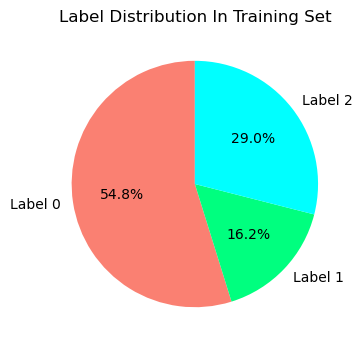

In [4]:
y_train_imbalanced = y_train.value_counts().sort_index()
# class_weights = [y_train.shape[0] / item[1] for item in y_train_imbalanced.items()]
class_weights = {cls: y_train.shape[0] / count for cls, count in y_train_imbalanced.items()}
print("Class weight:", class_weights, '\n')
print(f"Train label count:\n{y_train_imbalanced}")

plt.figure(figsize=(4, 4))
plt.pie(y_train_imbalanced, labels=['Label 0', 'Label 1', 'Label 2'], autopct='%1.1f%%', startangle=90, colors=['salmon','springgreen', 'cyan'])
plt.title('Label Distribution In Training Set')
plt.show()

Valid label count:
0    4675
1    1381
2    2471
Name: CreditScore, dtype: int64


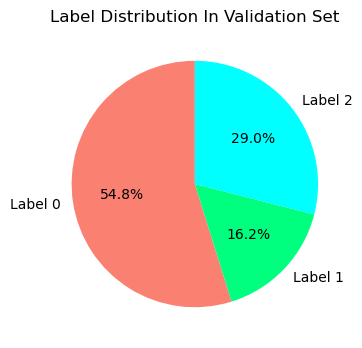

In [5]:
y_valid_imbalanced = y_valid.value_counts().sort_index()
print(f"Valid label count:\n{y_valid_imbalanced}")

plt.figure(figsize=(4, 4))
plt.pie(y_valid_imbalanced, labels=['Label 0', 'Label 1', 'Label 2'], autopct='%1.1f%%', startangle=90, colors=['salmon','springgreen', 'cyan'])
plt.title('Label Distribution In Validation Set')
plt.show()

### Data Preprocess

In [6]:
categorical_features = ['col_2', 'col_13', 'col_17', 'col_20']

# handle missing value
num_imputer = SimpleImputer(strategy='median')
X_train_num = num_imputer.fit_transform(X_train.drop(categorical_features, axis=1))
X_valid_num = num_imputer.transform(X_valid.drop(categorical_features, axis=1))

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train[categorical_features])
X_valid_cat = cat_imputer.transform(X_valid[categorical_features])

# Normalize
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_num)
X_valid_num = sc.transform(X_valid_num)

# PCA
# ratio = 0.9
# n_components = int(X_train_num.shape[1] * ratio)
# pca = PCA(n_components=n_components)
# X_train_num = pca.fit_transform(X_train_num)
# X_valid_num = pca.transform(X_valid_num)

# One Hot Encoding
encoder = OneHotEncoder()
X_train_cat = encoder.fit_transform(X_train_cat).toarray()
X_valid_cat = encoder.transform(X_valid_cat).toarray()


In [7]:
X_train = np.hstack([X_train_num, X_train_cat])
X_valid = np.hstack([X_valid_num, X_valid_cat])
print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

Train: (76743, 46), Valid: (8527, 46)


In [8]:
# Smote
# Smote
smote = SMOTE(random_state=42)
smote_enn = SMOTEENN()
smote_tomek = SMOTETomek(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)
X_train_tomek, y_train_tomek = smote_tomek.fit_resample(X_train, y_train)

### Ensemble Model

In [9]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
)

rf.fit(X_train_tomek, y_train_tomek)

y_pred_train = rf.predict(X_train)
y_pred_val =  rf.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

F1-score on train: 0.9835825890332542
F1-score on valid: 0.7813122764812023


In [ ]:
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=7, 
    early_stopping_rounds=50,
    reg_lambda=1.2, 
    min_child_weight=4,
    n_jobs=-1
)

eval_set = [(X_train_smote, y_train_smote), (X_valid, y_valid)]

xgb.fit(X_train_smote, y_train_smote, eval_set=eval_set, verbose=10)

y_pred_train = xgb.predict(X_train)
y_pred_val =  xgb.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 


[0]	validation_0-mlogloss:0.92254	validation_1-mlogloss:0.95068
[10]	validation_0-mlogloss:0.55804	validation_1-mlogloss:0.67496
[20]	validation_0-mlogloss:0.48450	validation_1-mlogloss:0.63631
[30]	validation_0-mlogloss:0.44907	validation_1-mlogloss:0.62150
[40]	validation_0-mlogloss:0.41986	validation_1-mlogloss:0.61031
[50]	validation_0-mlogloss:0.39615	validation_1-mlogloss:0.60019
[60]	validation_0-mlogloss:0.37588	validation_1-mlogloss:0.59215
[70]	validation_0-mlogloss:0.35694	validation_1-mlogloss:0.58292
[80]	validation_0-mlogloss:0.33776	validation_1-mlogloss:0.57433
[90]	validation_0-mlogloss:0.32269	validation_1-mlogloss:0.56885
[100]	validation_0-mlogloss:0.30801	validation_1-mlogloss:0.56348
[110]	validation_0-mlogloss:0.29353	validation_1-mlogloss:0.55802
[120]	validation_0-mlogloss:0.28224	validation_1-mlogloss:0.55474
[130]	validation_0-mlogloss:0.27156	validation_1-mlogloss:0.55084
[140]	validation_0-mlogloss:0.26240	validation_1-mlogloss:0.54709
[150]	validation_0-ml

In [ ]:
# lgb = LGBMClassifier(
#   # n_estimators=500, 
#   # max_depth=7, 
#   # num_leaves=101,
#   # min_child_samples=8,
#   # reg_lambda=1.2, 
#   # early_stopping_rounds=50,
#   # is_unbalance=True,
#   # scale_pos_weight=2,
#   # objective='multiclass',
#   n_jobs=-1,
#   verbose=10
# )

# lgb.fit(X_train, y_train)

# y_pred_train = lgb.predict(X_train)
# y_pred_val =  lgb.predict(X_valid)

# print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
# print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

In [10]:
cat = CatBoostClassifier(
    iterations=8000,
    class_weights=class_weights,
    early_stopping_rounds=50,
    devices='0:1',
    verbose=True
)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=10)

y_pred_train = cat.predict(X_train)
y_pred_val =  cat.predict(X_valid)

print(f"F1-score on train: {f1_score(y_train, y_pred_train, average='macro')}") 
print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}") 

Learning rate set to 0.053217
0:	learn: 1.0666283	test: 1.0657733	best: 1.0657733 (0)	total: 66.4ms	remaining: 8m 51s
10:	learn: 0.8737706	test: 0.8692045	best: 0.8692045 (10)	total: 156ms	remaining: 1m 53s
20:	learn: 0.7943364	test: 0.7867632	best: 0.7867632 (20)	total: 244ms	remaining: 1m 32s
30:	learn: 0.7565235	test: 0.7470497	best: 0.7470497 (30)	total: 330ms	remaining: 1m 24s
40:	learn: 0.7356044	test: 0.7250791	best: 0.7250791 (40)	total: 414ms	remaining: 1m 20s
50:	learn: 0.7229262	test: 0.7119657	best: 0.7119657 (50)	total: 499ms	remaining: 1m 17s
60:	learn: 0.7148784	test: 0.7038552	best: 0.7038552 (60)	total: 583ms	remaining: 1m 15s
70:	learn: 0.7088149	test: 0.6983020	best: 0.6983020 (70)	total: 664ms	remaining: 1m 14s
80:	learn: 0.7040777	test: 0.6940296	best: 0.6940296 (80)	total: 746ms	remaining: 1m 12s
90:	learn: 0.7003800	test: 0.6909038	best: 0.6909038 (90)	total: 827ms	remaining: 1m 11s
100:	learn: 0.6971400	test: 0.6879447	best: 0.6879447 (100)	total: 909ms	remainin

In [14]:
def custom_predict(model, X):
    y_pred = model.predict(X)
    if y_pred.ndim > 1:
        y_pred = y_pred.reshape(-1)
    return y_pred

y_pred_xgb = custom_predict(xgb, X_valid)
y_pred_rf = custom_predict(rf, X_valid)
y_pred_cat = custom_predict(cat, X_valid)

y_preds = np.vstack([y_pred_xgb, y_pred_rf, y_pred_cat])
y_pred_val = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_preds)

print(f"F1-score on valid: {f1_score(y_valid, y_pred_val, average='macro')}")

F1-score on valid: 0.7858222759079186


### Output Result

In [11]:
df_test = pd.read_csv('test.csv')

df_test.head(5)

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21
0,26,8,62846.31,NaN,9,8,20,7,40,18.0,...,10.0,0,4073.62,32.455597,27,2,284.982920,182.480461,4.0,321.855869
1,26,8,44632.44,3419.370000,10,6,33,5,15,18.0,...,6.0,0,3409.13,39.326411,77,2,154.142311,394.730183,3.0,83.064506
2,41,9,28062.39,NaN,5,5,7,1,25,1.0,...,3.0,1,839.85,36.592743,217,1,14.835135,21.867753,5.0,443.050363
3,37,11,88406.34,NaN,2,7,12,4,10,3.0,...,3.0,1,1273.15,25.823064,378,1,242.236850,203.656866,4.0,515.425785
4,38,6,30739.30,2298.608333,4,4,13,6,15,10.0,...,4.0,2,1365.58,29.727568,213,2,135.238141,24.695750,4.0,319.926942


In [12]:
# Data Preprocess
X_test_num = num_imputer.transform(df_test.drop(categorical_features, axis=1))
X_test_cat = cat_imputer.transform(df_test[categorical_features])

X_test_num = sc.transform(X_test_num)
X_test_cat = encoder.transform(X_test_cat).toarray()

X_test = np.hstack([X_test_num, X_test_cat])

print("Test shape:", X_test.shape)

Test shape: (6762, 46)


In [13]:
# Predict
y_pred = cat.predict(X_test).flatten()
# y_pred = xgb.predict(X_test).flatten()
# y_pred = random_forest.predict(X_test).flatten()

# y_pred_xgb = custom_predict(xgb, X_test)
# y_pred_rf = custom_predict(rf, X_test)
# y_pred_cat = custom_predict(cat, X_test)
# y_preds = np.vstack([y_pred_xgb, y_pred_rf, y_pred_cat])
# y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=y_preds)

# print(y_pred.shape)

In [14]:
# Output
output_df = pd.DataFrame({
    'Id': range(len(y_pred)),  
    'label': y_pred           
})

output_df.to_csv('output.csv', index=False)

print(output_df)
print("\nLabel Distribution:")
print(output_df['label'].value_counts().sort_index())

        Id  label
0        0      2
1        1      0
2        2      2
3        3      0
4        4      0
...    ...    ...
6757  6757      2
6758  6758      0
6759  6759      0
6760  6760      0
6761  6761      1

[6762 rows x 2 columns]

Label Distribution:
0    2401
1    2080
2    2281
Name: label, dtype: int64
